In [ ]:
# cd E:\S3B_OLCI\S3B_OL_1_EFR____20221024T040406_20221024T040706_20221024T210705_0180_072_047_2340_PS2_O_NT_003\S3B_OL_1_EFR____20221024T040406_20221024T040706_20221024T210705_0180_072_047_2340_PS2_O_NT_003.SEN3

In [1]:
cd E:\S3B_OLCI\New folder

E:\S3B_OLCI\New folder


In [2]:
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob

from IPython.display import HTML

# Python libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from skimage import exposure

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

In [ ]:
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[8])

In [ ]:
olci_xr = xr.open_dataset('Oa01_radiance.nc')
olci_xr

In [ ]:
olci_xr_mf = xr.open_mfdataset('*_radiance.nc', combine='by_coords')
olci_xr_mf

In [ ]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa08_radiance'].plot.imshow()

In [ ]:
olci_geo_coords = xr.open_dataset('geo_coordinates.nc')
olci_geo_coords

In [ ]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

In [9]:
def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    """ 
    Selects the channels / bands of a multi-dimensional xarray for red, green and blue composites.
    
    Parameters:
        xarray(xarray Dataset): xarray Dataset object that stores the different channels / bands.
        red_channel(str): Name of red channel to be selected
        green_channel(str): Name of green channel to be selected
        blue_channel(str): Name of blue channel to be selected

    Returns:
        Three xarray DataArray objects with selected channels / bands
    """  
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]

In [ ]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
red

In [15]:
def normalize(array):
    """ 
    Normalizes a numpy array / xarray DataArray object value to values between 0 and 1.
    
    Parameters:
        xarray(numpy array or xarray DataArray): xarray DataArray or numpy array object.

    Returns:
        Normalized array
    """ 
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [ ]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [ ]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

In [ ]:
rgb = exposure.equalize_adapthist(rgb)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

In [ ]:
mesh_rgb = rgb[:, :, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

In [72]:
def visualize_s3_pcolormesh(a_color_array, a_array, a_latitude, a_longitude, 
                           b_color_array, b_array, b_latitude, b_longitude, 
                           c_color_array, c_array, c_latitude, c_longitude, track_lon,track_lat,title,):
    """ 
    Visualizes a numpy array (Sentinel-3 data) with matplotlib's 'pcolormesh' function as composite.
    
    Parameters:
        color_array (numpy MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        longitude (numpy Array): array with longitude values
        latitude (numpy Array) : array with latitude values
        title (str): title of the resulting plot
    """
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=ccrs.Mercator())
    ax.coastlines()
    ax.set_extent([68,98,8,38]) # Mediterranean

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}
    
    img1 = plt.pcolormesh(a_longitude, a_latitude, a_array*np.nan, color=a_colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree()
                          )
#***********************************************************************
    img2 = plt.pcolormesh(b_longitude, b_latitude, b_array*np.nan, color=b_colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree()
                          )
    img2 = plt.pcolormesh(c_longitude, c_latitude, c_array*np.nan, color=c_colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree()
                          )
#************************************************************************
    ax.plot(track_lon,track_lat,lw=2,color='red',transform=ccrs.PlateCarree())
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.savefig('Sentinel3_RGB0.jpg',dpi= 720)
#     plt.show()

In [ ]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 True Colour - "07 August 2021"')

In [ ]:
geo_a = xr.open_dataset('a_geo_coordinates.nc')
geo_b = xr.open_dataset('b_geo_coordinates.nc')
geo_c = xr.open_dataset('c_geo_coordinates.nc')
geo_d = xr.open_dataset('d_geo_coordinates.nc')


In [ ]:
from rasterio.merge import merge
geo_coordinates = xr.merge([geo_a.altitude,geo_b.altitude,geo_c.altitude,geo_d.altitude])

# altitude
# (rows, columns)
# float32
# ...
# latitude
# (rows, columns)
# float64
# ...
# longitude

# Combined 

In [5]:
a = xr.open_mfdataset('a*_radiance.nc', combine='by_coords')
b = xr.open_mfdataset('b*_radiance.nc', combine='by_coords')
c = xr.open_mfdataset('c*_radiance.nc', combine='by_coords')
d = xr.open_mfdataset('d*_radiance.nc', combine='by_coords')

In [12]:
a

<xarray.Dataset>
Dimensions:        (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
Attributes: (12/17)
    absolute_orbit_number:  23419
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2022-10-24T21:07:05Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r5 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.13
    start_time:             2022-10-24T04:04:06.454622Z
    stop_time:              2022-10-24T04:07:06.378431Z
    title:                  OLCI Level 1b Product, Radiance Oa04 Data Set

In [6]:
a_geo_coords = xr.open_dataset('a_geo_coordinates.nc')
b_geo_coords = xr.open_dataset('b_geo_coordinates.nc')
c_geo_coords = xr.open_dataset('c_geo_coordinates.nc')
d_geo_coords = xr.open_dataset('d_geo_coordinates.nc')


In [7]:
a_lat = a_geo_coords.latitude.data
a_lon = a_geo_coords.longitude.data
b_lat = b_geo_coords.latitude.data
b_lon = b_geo_coords.longitude.data
c_lat = c_geo_coords.latitude.data
c_lon = c_geo_coords.longitude.data
d_lat = d_geo_coords.latitude.data
d_lon = d_geo_coords.longitude.data


In [13]:
a_red, a_green, a_blue = select_channels_for_rgb(a, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
b_red, b_green, b_blue = select_channels_for_rgb(b, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
c_red, c_green, c_blue = select_channels_for_rgb(c, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
d_red, d_green, d_blue = select_channels_for_rgb(d, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')


In [16]:
a_redn = normalize(a_red)
a_greenn = normalize(a_green)
a_bluen = normalize(a_blue)
b_redn = normalize(b_red)
b_greenn = normalize(b_green)
b_bluen = normalize(b_blue)
c_redn = normalize(c_red)
c_greenn = normalize(c_green)
c_bluen = normalize(c_blue)


In [17]:
a_rgb = np.dstack((a_redn, a_greenn, a_bluen))
b_rgb = np.dstack((b_redn, b_greenn, b_bluen))
c_rgb = np.dstack((c_redn, c_greenn, c_bluen))


In [18]:
a_rgb = exposure.equalize_adapthist(a_rgb)
b_rgb = exposure.equalize_adapthist(b_rgb)
c_rgb = exposure.equalize_adapthist(c_rgb)


In [19]:
a_mesh_rgb = a_rgb[:, :, :]
a_colorTuple = a_mesh_rgb.reshape((a_mesh_rgb.shape[0] * a_mesh_rgb.shape[1]), 3)
a_colorTuple = np.insert(a_colorTuple, 3, 1.0, axis=1)
b_mesh_rgb = b_rgb[:, :, :]
b_colorTuple = b_mesh_rgb.reshape((b_mesh_rgb.shape[0] * b_mesh_rgb.shape[1]), 3)
b_colorTuple = np.insert(b_colorTuple, 3, 1.0, axis=1)
c_mesh_rgb = c_rgb[:, :, :]
c_colorTuple = c_mesh_rgb.reshape((c_mesh_rgb.shape[0] * c_mesh_rgb.shape[1]), 3)
c_colorTuple = np.insert(c_colorTuple, 3, 1.0, axis=1)

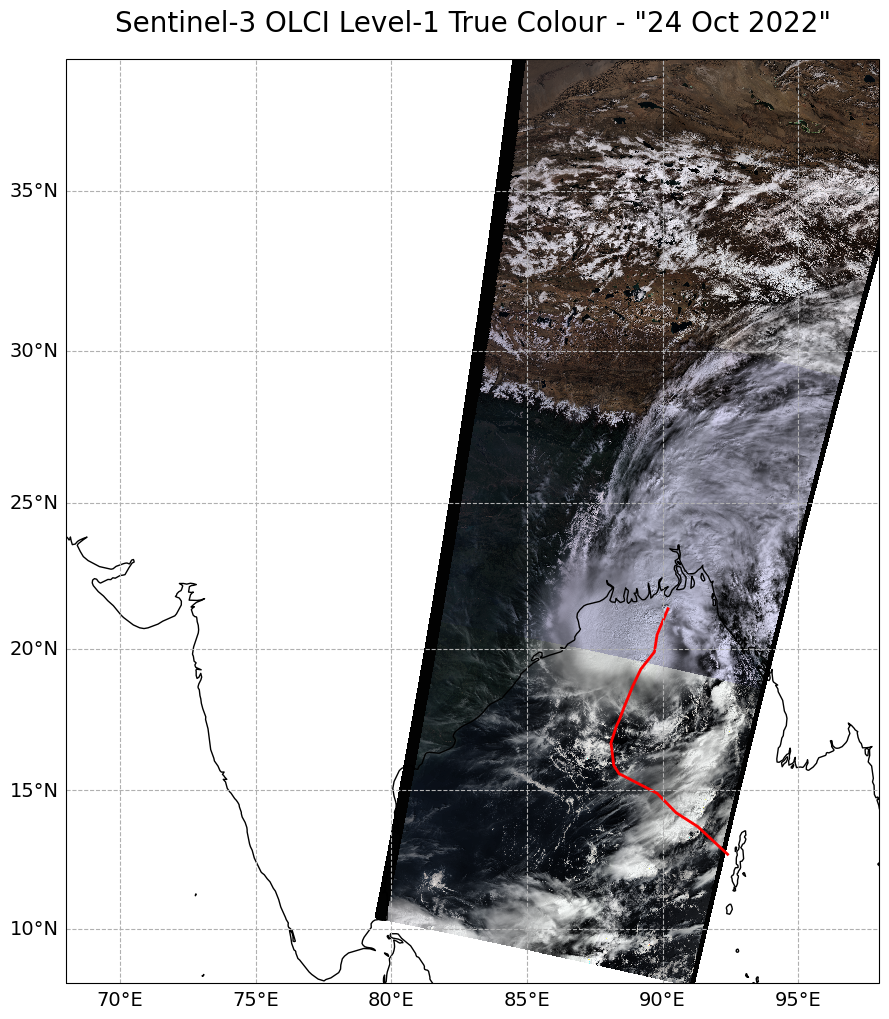

In [73]:
visualize_s3_pcolormesh(a_color_array=a_colorTuple,
                        a_array=a_red, 
                        a_latitude=a_lat, 
                        a_longitude=a_lon, 
                        b_color_array=b_colorTuple,
                        b_array=b_red, 
                        b_latitude=b_lat, 
                        b_longitude=b_lon, 
                        c_color_array=c_colorTuple,
                        c_array=c_red, 
                        c_latitude=c_lat, 
                        c_longitude=c_lon, 
                        track_lon =track['Centre long'],
                        track_lat =track['Centre lat'],
                        title='Sentinel-3 OLCI Level-1 True Colour - "24 Oct 2022"')

In [30]:
track = pd.read_excel(r'C:\Users\mohan\Downloads\Sitrang_best_track.xlsx')

In [31]:
track

,Date,Time (UTC),Centre lat,Centre long,C.I. NO.,Estimated Central Pressure (hPa),Estimated Maximum Sustained Surface Wind (kt),Estimated Pressure drop at the Centre (hPa),Grade
0,2022-10-22,03:00:00,12.7,92.4,1.5,1004.0,25.0,3.0,D
1,2022-10-22,06:00:00,13.7,91.3,1.5,1003.0,25.0,4.0,D
2,2022-10-22,12:00:00,14.2,90.5,1.5,1002.0,25.0,4.0,D
3,2022-10-22,18:00:00,14.9,89.8,1.5,1002.0,25.0,4.0,D
4,2022-10-23,1900-01-01 00:00:00,15.3,89.0,2.0,1001.0,30.0,5.0,DD
5,2022-10-23,1900-01-01 03:00:00,15.6,88.4,2.0,1000.0,30.0,6.0,DD
6,2022-10-23,1900-01-01 06:00:00,15.9,88.2,2.0,1000.0,30.0,6.0,DD
7,2022-10-23,1900-01-01 12:00:00,16.7,88.1,2.5,999.0,35.0,7.0,CS
8,2022-10-23,1900-01-01 15:00:00,17.0,88.2,2.5,999.0,35.0,7.0,CS
9,2022-10-23,1900-01-01 18:00:00,17.3,88.3,2.5,998.0,35.0,7.0,CS


In [35]:
track.columns

Index(['Date', 'Time (UTC)', 'Centre lat', 'Centre long', 'C.I. NO.',
       'Estimated Central Pressure (hPa)',
       'Estimated Maximum Sustained Surface Wind (kt)',
       'Estimated Pressure drop at the Centre (hPa)', 'Grade'],
      dtype='object')

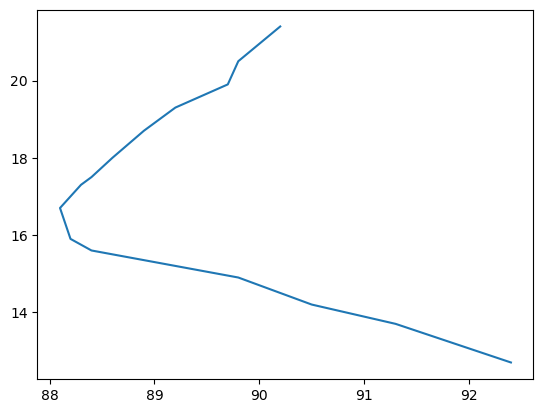

In [37]:
plt.plot(track['Centre long'],track['Centre lat'])

In [38]:
cd

C:\Users\mohan


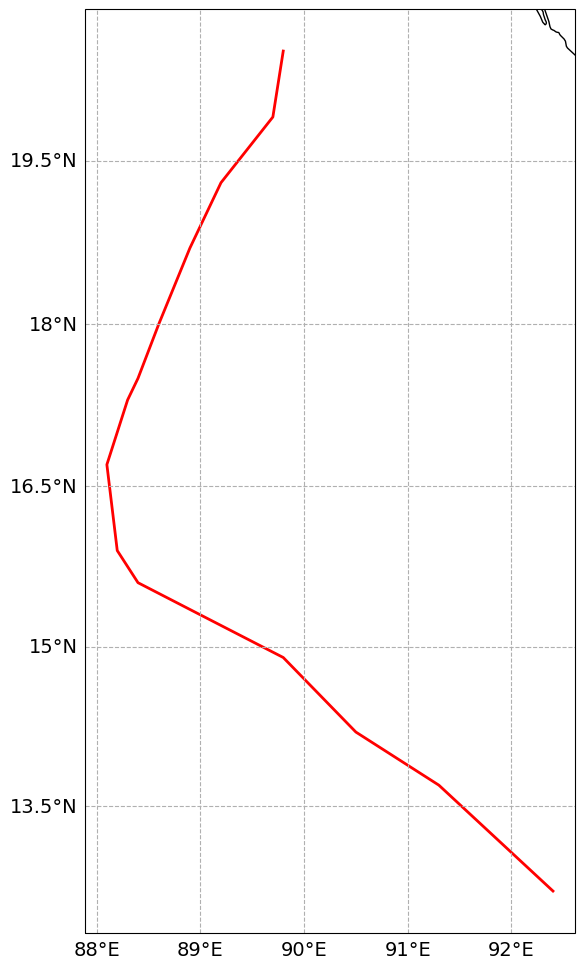

In [70]:
track_lon=track['Centre long']
track_lat=track['Centre lat']
title='Sentinel-3 OLCI Level-1 True Colour - "24 Oct 2022"'
mer = ccrs.Mercator()
geodetic = ccrs.Geodetic()
# lats,lons =  mer.transform_point(track_lon,track_lat,geodetic)
 


fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.Mercator())
ax.coastlines()
# ax.set_extent([68,98,8,38]) # Mediterranean
ax.plot(np.array(track_lon[0:16]),np.array(track_lat[0:16]),lw=2,color='red',transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}
    

#************************************************************************

# ax.set_title(title, fontsize=20, pad=20.0)
# plt.savefig('Sentinel3_RGB.jpg',dpi= 720)
plt.show()

In [55]:
track['Centre long'][0:16]#,track['Centre lat']

0     92.4
1     91.3
2     90.5
3     89.8
4     89.0
5     88.4
6     88.2
7     88.1
8     88.2
9     88.3
10    88.4
11    88.6
12    88.9
13    89.2
14    89.7
15    89.8
16    90.2
17     NaN
Name: Centre long, dtype: float64

In [65]:
track_lat[0:16]

0     12.7
1     13.7
2     14.2
3     14.9
4     15.3
5     15.6
6     15.9
7     16.7
8     17.0
9     17.3
10    17.5
11    18.0
12    18.7
13    19.3
14    19.9
15    20.5
Name: Centre lat, dtype: float64

In [66]:
import cartopy.crs as ccrs

In [ ]:
ccrs.Mercator